<a href="https://colab.research.google.com/github/kommurisi/Individual_SiddiKommuri_HandlingMissingData-Titanic/blob/main/Siddi_ForecastingAirLinePassengers_002374754.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crash Course in Forecasting — Airline Passengers (Monthly)

*Siddi Suhas · 002374754*

**Goal.** A practical, self-contained chapter for univariate time-series forecasting:
EDA → decomposition → stationarity tests → baselines → exponential smoothing (Holt–Winters) → SARIMA grid search → residual diagnostics → time-series CV → prediction intervals → final forecast. Plenty of plots, minimal theory jargon.


## Why Forecast?

Forecasts inform decisions **today** about quantities realized **tomorrow**:
- **Business:** demand, inventory, staffing, cash flow, churn.
- **Operations:** energy load, call-center volume, ride-hailing supply.
- **Economics:** CPI, GDP nowcasting, unemployment claims.
- **Product/Data:** DAU/MAU, ad impressions, server capacity.

A good forecasting system balances **accuracy**, **timeliness**, **explainability**, and **robustness** under change.


## Problem Framing

Specify before modeling:
- **Target series (Y):** what are we forecasting? Units? Aggregation (daily, weekly, monthly)?
- **Horizon (h):** how many steps ahead? (e.g., h=12 months)
- **Cadence:** one-shot (batch) vs rolling (recurring) forecasts.
- **Granularity:** single series, multiple related series, or a hierarchy (store → region → national)?
- **Exogenous X (a.k.a. covariates, regressors):** promotions, price, holidays, weather.
- **Loss / KPI:** MAE/RMSE/MAPE/Pinball loss; cost asymmetry (over- vs under-forecast).
- **Operational constraints:** latency, frequency, automation, intervention points, guardrails.


## Problem Framing

Specify before modeling:
- **Target series (Y):** what are we forecasting? Units? Aggregation (daily, weekly, monthly)?
- **Horizon (h):** how many steps ahead? (e.g., h=12 months)
- **Cadence:** one-shot (batch) vs rolling (recurring) forecasts.
- **Granularity:** single series, multiple related series, or a hierarchy (store → region → national)?
- **Exogenous X (a.k.a. covariates, regressors):** promotions, price, holidays, weather.
- **Loss / KPI:** MAE/RMSE/MAPE/Pinball loss; cost asymmetry (over- vs under-forecast).
- **Operational constraints:** latency, frequency, automation, intervention points, guardrails.


## Vocabulary

- **Trend:** long-term increase/decrease.
- **Seasonality:** repeating patterns with fixed period (daily/weekly/monthly).
- **Cyclical:** longer, irregular oscillations.
- **Noise:** idiosyncratic variation.
- **Stationarity:** stable mean/variance/covariance over time.
- **Exogenous regressors (X):** outside signals used to explain Y.
- **Backtesting:** historical simulation of future forecasts (a.k.a. time-series cross-validation).
- **Prediction interval (PI):** range (e.g., 80%, 95%) capturing forecast uncertainty.


## What We’ll Build Next

We’ll implement a complete pipeline on **Airline Passengers (monthly)**:
1) EDA & decomposition (classical + STL)  
2) Stationarity checks + transforms (log, differencing)  
3) Baselines (Naive, Seasonal Naive, Moving Avg)  
4) ETS (Holt–Winters) variants  
5) SARIMA grid (compact, robust)  
6) Residual diagnostics (ACF/PACF, Ljung–Box)  
7) Rolling-origin CV (vs Seasonal Naive)  
8) Final refit on full data with **prediction intervals**  
9) Error-by-month analysis & conclusions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

sns.set_theme(style="whitegrid")
%matplotlib inline
np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)  # columns: Month, Passengers
data["Month"] = pd.to_datetime(data["Month"])
data = data.set_index("Month").asfreq("MS")
y = data["Passengers"].astype(float)

print(y.head(), "\n\nfreq:", y.index.freq)


Month
1949-01-01   112.000
1949-02-01   118.000
1949-03-01   132.000
1949-04-01   129.000
1949-05-01   121.000
Freq: MS, Name: Passengers, dtype: float64 

freq: <MonthBegin>


## 2. Exploratory Analysis

We first confirm frequency, visualize the series, month-of-year patterns, and rolling summaries. This dataset is classic for **multiplicative seasonality** (peaks grow with the level).


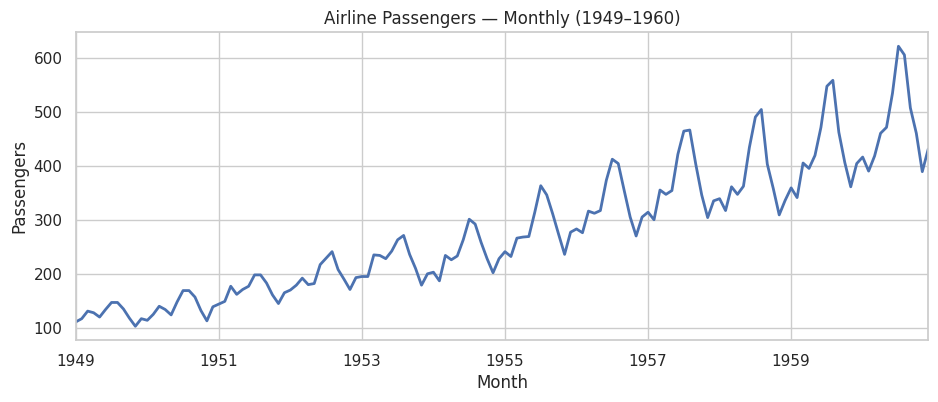

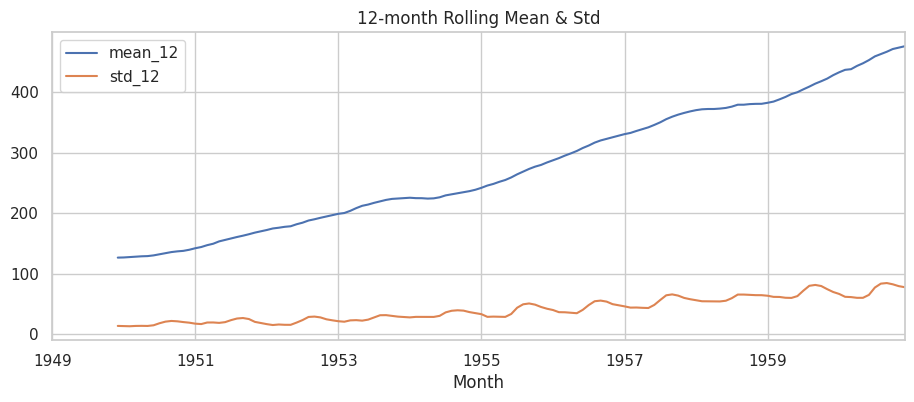

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(11,4))
y.plot(ax=ax, color='C0', lw=2)
ax.set_title("Airline Passengers — Monthly (1949–1960)")
ax.set_ylabel("Passengers")
plt.show()

roll = pd.DataFrame({
    "mean_12": y.rolling(12).mean(),
    "std_12": y.rolling(12).std()
})
roll.plot(figsize=(11,4), title="12-month Rolling Mean & Std"); plt.show()


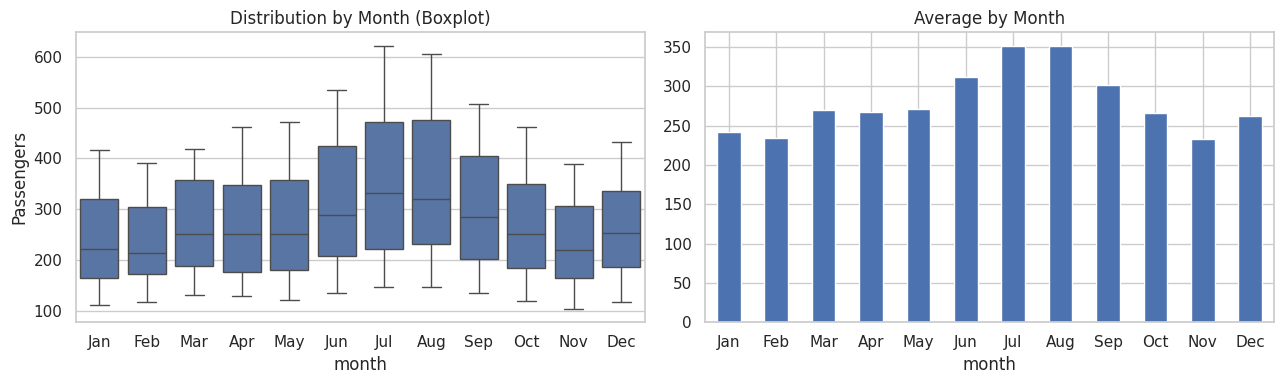

In [6]:
df = y.to_frame("Passengers").copy()
df["month"] = df.index.month_name().str[:3]
order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

fig, ax = plt.subplots(1,2,figsize=(13,4))
sns.boxplot(data=df, x="month", y="Passengers", order=order, ax=ax[0])
ax[0].set_title("Distribution by Month (Boxplot)")

monthly_mean = df.groupby("month")["Passengers"].mean().reindex(order)
monthly_mean.plot(kind="bar", ax=ax[1], rot=0, title="Average by Month")
plt.tight_layout(); plt.show()


## 3. Decomposition

We use both **classical multiplicative decomposition** and **STL** (Seasonal-Trend decomposition using Loess) to visualize trend/seasonality.


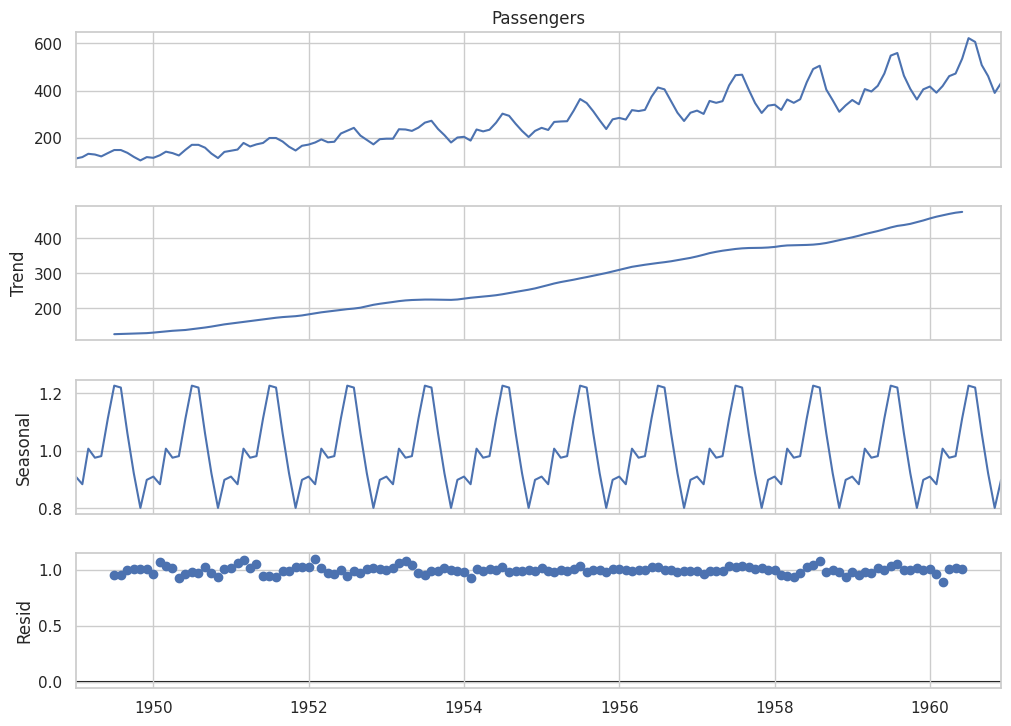

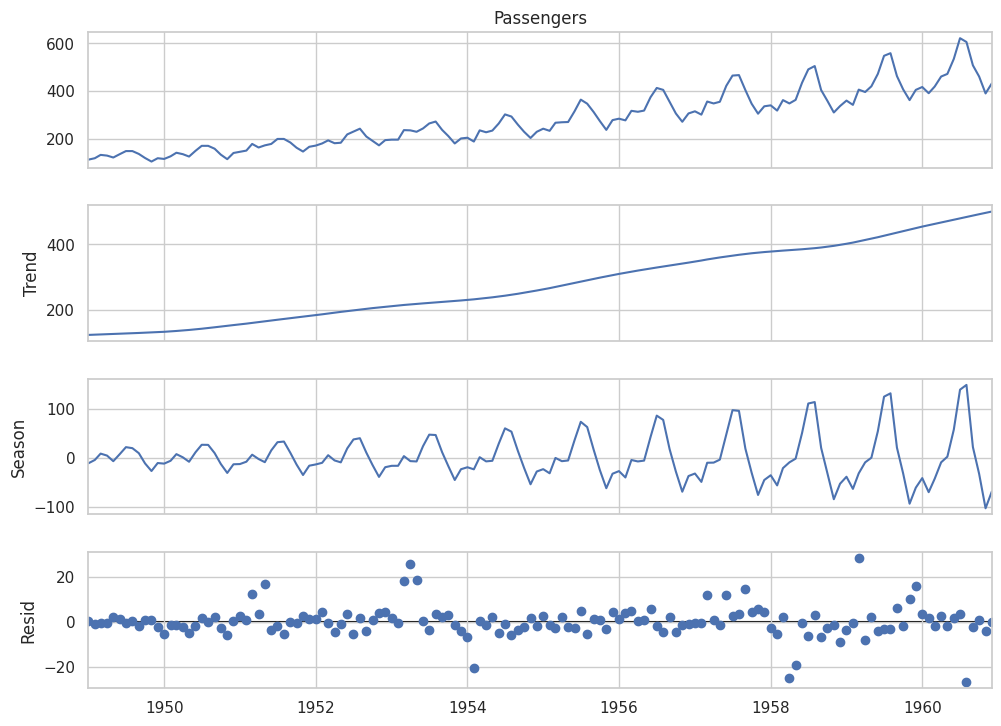

In [7]:
decomp = seasonal_decompose(y, model='multiplicative', period=12)
decomp.plot(); plt.gcf().set_size_inches(11,8); plt.show()

stl = STL(y, period=12, robust=True).fit()
stl.plot(); plt.gcf().set_size_inches(11,8); plt.show()


## 4. Stationarity Checks & Transforms

- Airline passengers show trend + multiplicative seasonality → variance grows with level.  
- Common trick: **log transform** to stabilize variance + seasonal differencing `∇_12` and/or first differencing `∇_1`.
- We’ll run **ADF test** at each step and inspect **ACF/PACF**.


In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def adf_report(series, name="series"):
    adf_stat, pval, *_ = adfuller(series.dropna())
    print(f"ADF ({name}): stat={adf_stat:.3f}, p={pval:.4f}")

def acf_pacf_plots(series, lags=36, title="ACF/PACF"):
    fig, axes = plt.subplots(1,2,figsize=(11,4))
    plot_acf(series.dropna(), ax=axes[0], lags=lags)
    plot_pacf(series.dropna(), ax=axes[1], lags=lags, method='ywm')
    fig.suptitle(title); plt.show()


ADF (y (levels)): stat=0.815, p=0.9919


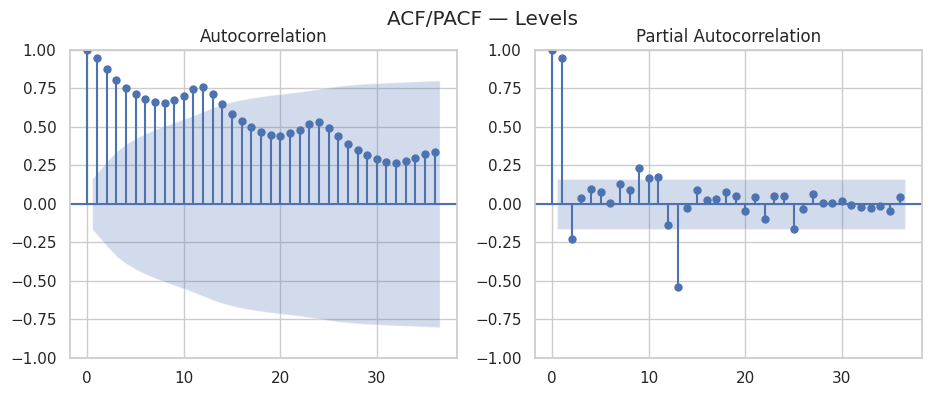

ADF (log(y)): stat=-1.717, p=0.4224


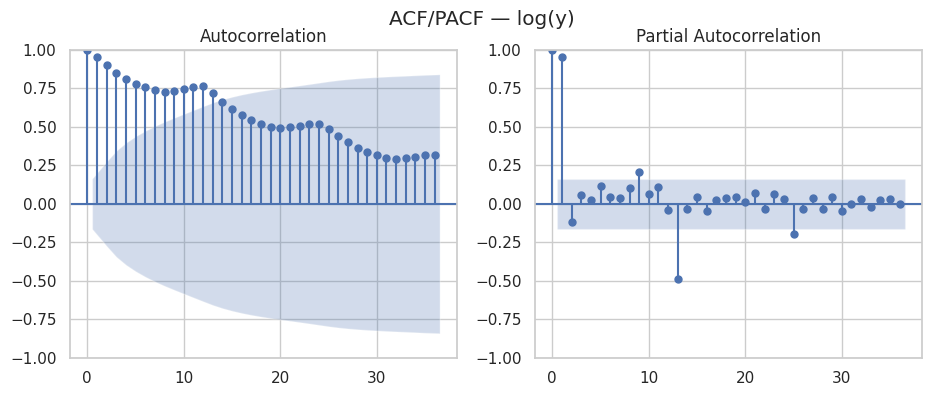

ADF (log(y) seasonal diff 12): stat=-2.710, p=0.0724


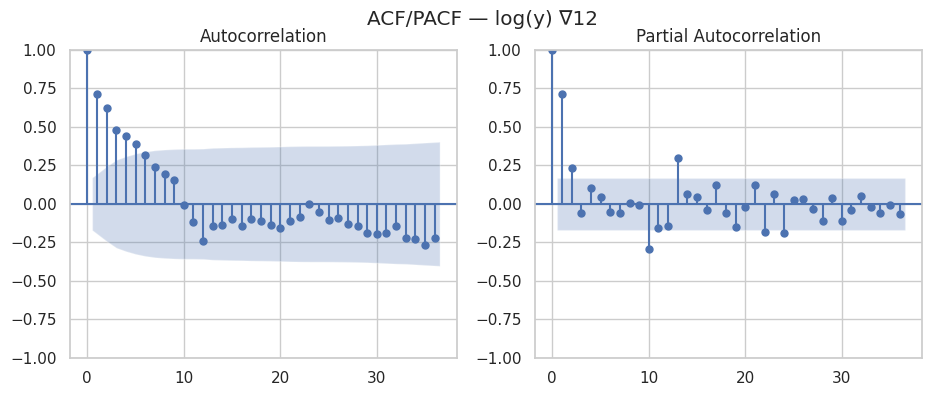

ADF (log(y) ∇12 ∇1): stat=-4.443, p=0.0002


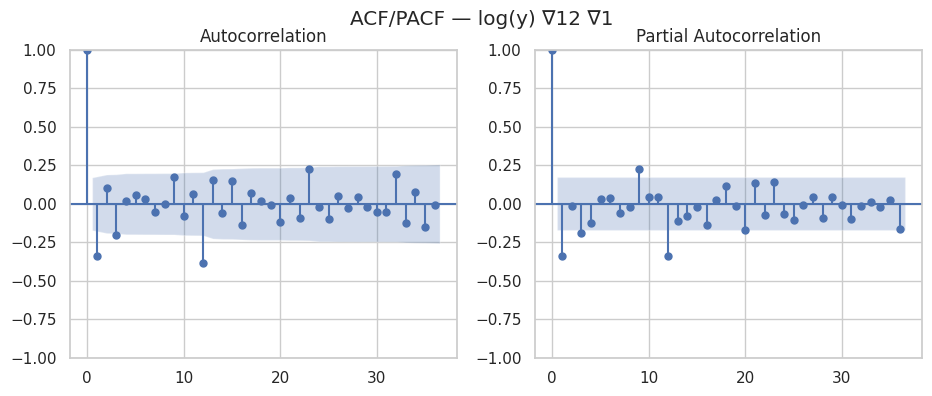

In [9]:
adf_report(y, "y (levels)")
acf_pacf_plots(y, title="ACF/PACF — Levels")

y_log = np.log(y)
adf_report(y_log, "log(y)")
acf_pacf_plots(y_log, title="ACF/PACF — log(y)")

y_log_d12 = y_log.diff(12)
adf_report(y_log_d12, "log(y) seasonal diff 12")
acf_pacf_plots(y_log_d12, title="ACF/PACF — log(y) ∇12")

y_log_d12_d1 = y_log.diff(12).diff(1)
adf_report(y_log_d12_d1, "log(y) ∇12 ∇1")
acf_pacf_plots(y_log_d12_d1, title="ACF/PACF — log(y) ∇12 ∇1")


## 5. Train / Validation Split

Hold out the last **24 months** for validation. We’ll use this for model selection.


In [10]:
h = 24
y_train, y_valid = y.iloc[:-h], y.iloc[-h:]
y_train.tail(), y_valid.head()


(Month
 1958-08-01   505.000
 1958-09-01   404.000
 1958-10-01   359.000
 1958-11-01   310.000
 1958-12-01   337.000
 Freq: MS, Name: Passengers, dtype: float64,
 Month
 1959-01-01   360.000
 1959-02-01   342.000
 1959-03-01   406.000
 1959-04-01   396.000
 1959-05-01   420.000
 Freq: MS, Name: Passengers, dtype: float64)

## 6. Metrics & Helpers
We use MAE, RMSE, and MAPE on the validation horizon.


In [11]:
def mape(y_true, y_pred):
    return (np.abs((y_true - y_pred) / y_true)).mean() * 100

def score(y_true, y_pred, name):
    return pd.Series({
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAPE%": mape(y_true, y_pred)
    })


## 7. Baselines

- **Naive**: last observed value.  
- **Seasonal Naive**: value from the same month one year ago.  
- **Moving Average**: last 12 months mean (flat forecast).


In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def _rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return (np.abs((y_true - y_pred) / y_true)).mean() * 100

def score(y_true, y_pred, name):
    # Align and drop NaNs in predictions (and corresponding truth)
    y_true = y_true.reindex(y_pred.index)
    mask = ~y_pred.isna()
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return pd.Series({
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": _rmse(y_true, y_pred),
        "MAPE%": mape(y_true, y_pred)
    })


,Model,MAE,RMSE,MAPE%
1,Seasonal Naive,47.583,49.987,10.523
2,Moving Avg (12),77.833,103.215,15.473
0,Naive,115.250,137.329,23.577


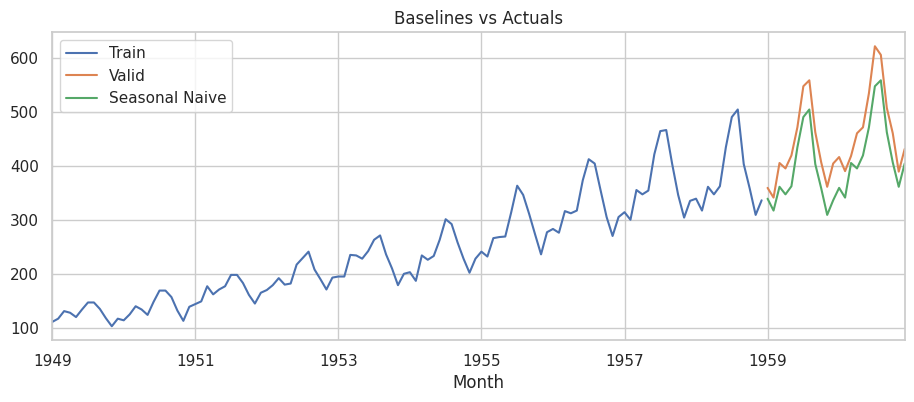

In [17]:
# Naive: constant = last train value
naive = pd.Series(y_train.iloc[-1], index=y_valid.index)

# Seasonal Naive: use full series shift(12)
snaive = y.shift(12).reindex(y_valid.index)

# Moving average (k=12): flat forecast = last 12-month mean from train
ma_k = 12
ma = pd.Series(y_train.rolling(ma_k).mean().iloc[-1], index=y_valid.index)

baseline_scores = pd.concat([
    score(y_valid, naive, "Naive"),
    score(y_valid, snaive, "Seasonal Naive"),
    score(y_valid, ma, f"Moving Avg ({ma_k})")
], axis=1).T

display(baseline_scores.sort_values("RMSE"))

plt.figure(figsize=(11,4))
y_train.plot(label="Train")
y_valid.plot(label="Valid")
snaive.plot(label="Seasonal Naive")
plt.title("Baselines vs Actuals")
plt.legend(); plt.show()


## 8. Exponential Smoothing (ETS)

We compare:
- **Holt (exp trend)** — no seasonality  
- **HW multiplicative trend & multiplicative seasonality** (common for this dataset)  
- **HW multiplicative trend & additive seasonality** (alternative)


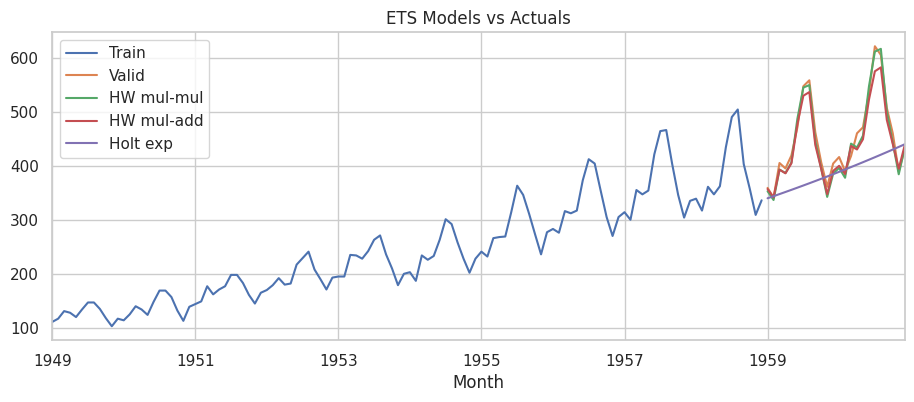

In [18]:
ets_scores = []

holt = Holt(y_train, exponential=True).fit()
pred_holt = holt.forecast(h)
ets_scores.append(score(y_valid, pred_holt, "Holt (exp trend)"))

hw_mul_mul = ExponentialSmoothing(y_train, trend='mul', seasonal='mul', seasonal_periods=12).fit()
pred_hw_mm = hw_mul_mul.forecast(h)
ets_scores.append(score(y_valid, pred_hw_mm, "HW (mul trend, mul seas)"))

hw_mul_add = ExponentialSmoothing(y_train, trend='mul', seasonal='add', seasonal_periods=12).fit()
pred_hw_ma = hw_mul_add.forecast(h)
ets_scores.append(score(y_valid, pred_hw_ma, "HW (mul trend, add seas)"))

ets_scores = pd.DataFrame(ets_scores).sort_values("RMSE")
ets_scores

plt.figure(figsize=(11,4))
y_train.plot(label="Train")
y_valid.plot(label="Valid")
pred_hw_mm.plot(label="HW mul-mul")
pred_hw_ma.plot(label="HW mul-add")
pred_holt.plot(label="Holt exp")
plt.title("ETS Models vs Actuals")
plt.legend(); plt.show()


## 9. SARIMA Grid (Small)

We search a compact grid:
- Non-seasonal (p,d,q) ∈ {0,1,2}
- Seasonal (P,D,Q,12) with P,D,Q ∈ {0,1}

Pick by **AIC** on train; evaluate on validation.


In [19]:
p = d = q = [0,1,2]
P = D = Q = [0,1]
seasonal_period = 12

results = []
best_aic = np.inf
best_sarima = None

for order in itertools.product(p,d,q):
    for sorder in itertools.product(P,D,Q):
        try:
            model = SARIMAX(y_train,
                            order=order,
                            seasonal_order=(sorder[0], sorder[1], sorder[2], seasonal_period),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)
            aic = model.aic
            results.append((order, sorder, aic))
            if aic < best_aic:
                best_aic = aic
                best_sarima = model
        except:
            pass

sarima_candidates = pd.DataFrame(results, columns=["order","seasonal_order","AIC"]).sort_values("AIC").head(10)
sarima_candidates


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,order,seasonal_order,AIC
67,"(0, 2, 2)","(0, 1, 1)",696.637
139,"(1, 2, 2)","(0, 1, 1)",697.902
71,"(0, 2, 2)","(1, 1, 1)",698.636
211,"(2, 2, 2)","(0, 1, 1)",699.886
143,"(1, 2, 2)","(1, 1, 1)",699.901
187,"(2, 1, 2)","(0, 1, 1)",700.922
47,"(0, 1, 2)","(1, 1, 1)",700.924
191,"(2, 1, 2)","(1, 1, 1)",700.926
215,"(2, 2, 2)","(1, 1, 1)",701.886
119,"(1, 1, 2)","(1, 1, 1)",702.482


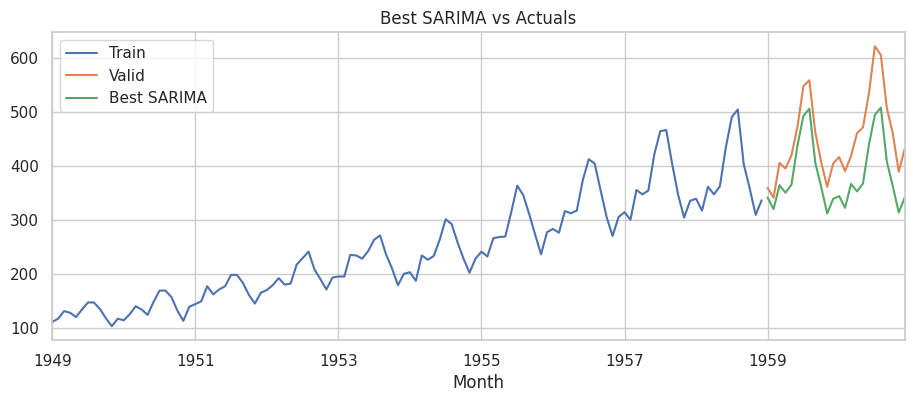

In [20]:
sarima_pred = best_sarima.forecast(h)
sarima_score = score(y_valid, sarima_pred, f"SARIMA {best_sarima.model_orders}")
sarima_score

plt.figure(figsize=(11,4))
y_train.plot(label="Train")
y_valid.plot(label="Valid")
sarima_pred.plot(label="Best SARIMA")
plt.title("Best SARIMA vs Actuals")
plt.legend(); plt.show()


## 10. Residual Diagnostics

A good model’s residuals should look like **white noise**:
- Zero mean, constant variance
- No autocorrelation (Ljung–Box test)
- Roughly normal (histogram/QQ is optional)


=== SARIMA Residual Diagnostics ===


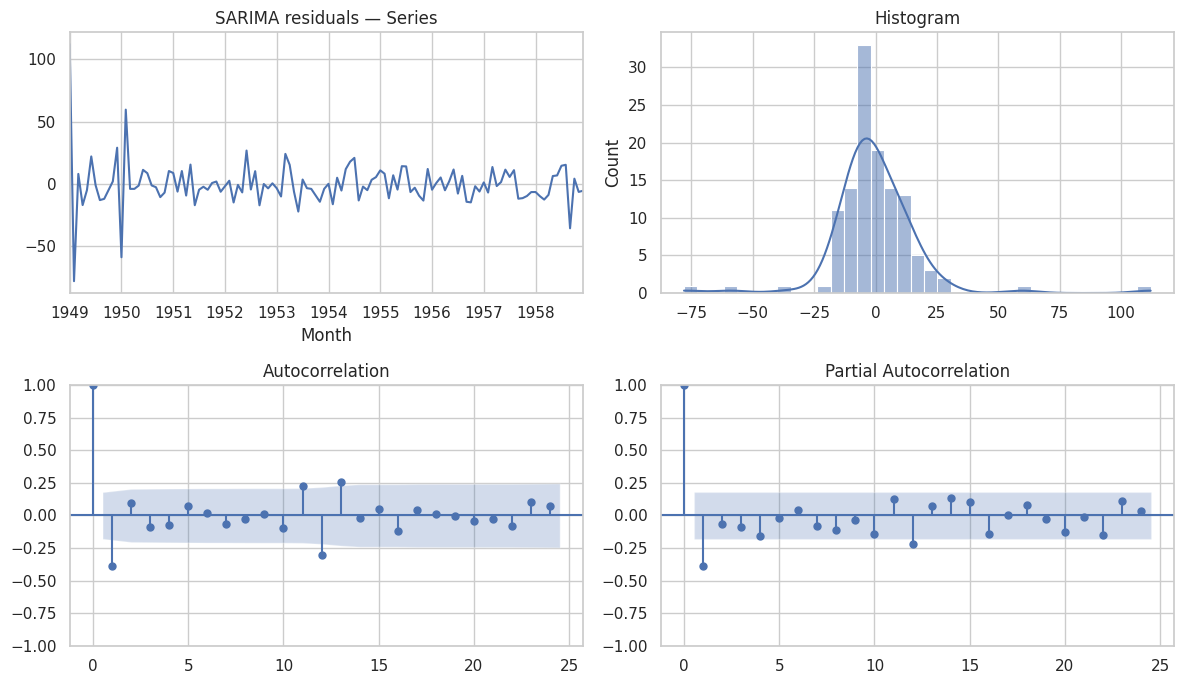

Ljung–Box p-values:
     lb_stat  lb_pvalue
12   42.759      0.000
24   58.092      0.000

=== HW mul-mul Residual Diagnostics ===


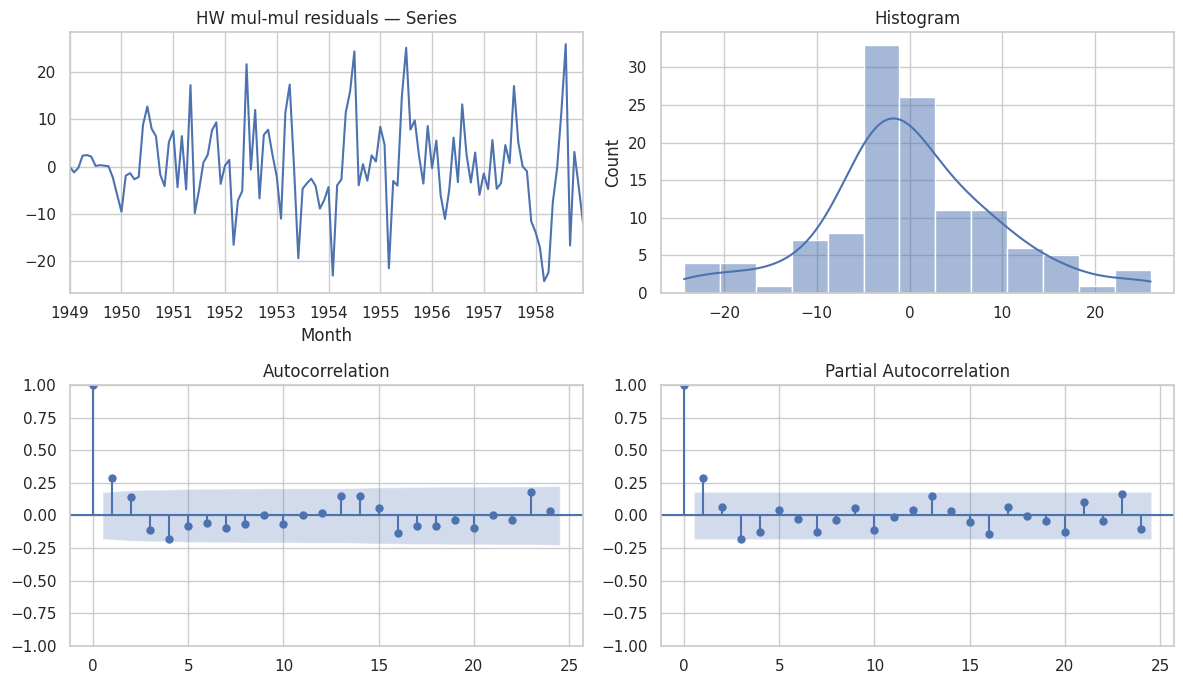

Ljung–Box p-values:
     lb_stat  lb_pvalue
12   21.950      0.038
24   39.830      0.022


In [21]:
def residual_diagnostics(residuals, lags=24, title="Residuals"):
    resid = pd.Series(residuals, index=y_train.index)
    fig, axes = plt.subplots(2,2,figsize=(12,7))
    resid.plot(ax=axes[0,0], title=f"{title} — Series")
    sns.histplot(resid, ax=axes[0,1], kde=True)
    axes[0,1].set_title("Histogram")
    plot_acf(resid.dropna(), lags=lags, ax=axes[1,0])
    plot_pacf(resid.dropna(), lags=lags, ax=axes[1,1], method='ywm')
    plt.tight_layout(); plt.show()
    lb = acorr_ljungbox(resid.dropna(), lags=[12,24], return_df=True)
    print("Ljung–Box p-values:\n", lb[["lb_stat","lb_pvalue"]])

print("=== SARIMA Residual Diagnostics ===")
residual_diagnostics(best_sarima.resid, lags=24, title="SARIMA residuals")

print("\n=== HW mul-mul Residual Diagnostics ===")
residual_diagnostics(hw_mul_mul.resid, lags=24, title="HW mul-mul residuals")


## 11. Model Comparison (Validation)

Scoreboard across Baselines, ETS, and SARIMA.


In [22]:
scoreboard = pd.concat([
    baseline_scores,
    ets_scores,
    pd.DataFrame([sarima_score])
], axis=0).sort_values("RMSE").reset_index(drop=True)

scoreboard


,Model,MAE,RMSE,MAPE%
0,"HW (mul trend, mul seas)",12.380,13.878,2.813
1,"HW (mul trend, add seas)",15.593,18.411,3.291
2,Seasonal Naive,47.583,49.987,10.523
3,"SARIMA {'trend': 0, 'exog': 0, 'ar': 0, 'ma': ...",67.664,73.359,14.715
4,Holt (exp trend),70.177,93.932,14.001
5,Moving Avg (12),77.833,103.215,15.473
6,Naive,115.250,137.329,23.577


## 12. Final Fit on Full Data & 12-Month Forecast

Refit the **winning** model on all data and produce a 12-month forecast with **prediction intervals**.


In [25]:
import numpy as np, pandas as pd, itertools, warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")

p = d = q = [0,1,2]
P = D = Q = [0,1]
m = 12  # monthly seasonality

results = []
best_model = None
best_aic = np.inf
best_order = None               # <-- store best (p,d,q)
best_seasonal = None            # <-- store best (P,D,Q,m)

def try_fit(order, sorder):
    for method, it in [("lbfgs", 1000), ("powell", 300)]:
        try:
            mdl = SARIMAX(
                y_train,
                order=order,
                seasonal_order=(sorder[0], sorder[1], sorder[2], m),
                enforce_stationarity=False,
                enforce_invertibility=False,
                trend="n",
            ).fit(disp=False, method=method, maxiter=it)
            return mdl
        except Exception:
            continue
    return None

for order in itertools.product(p,d,q):
    for sorder in itertools.product(P,D,Q):
        mdl = try_fit(order, sorder)
        aic = mdl.aic if mdl is not None else np.inf
        results.append((order, sorder, aic))
        if aic < best_aic:
            best_aic = aic
            best_model = mdl
            best_order = order                 # <-- record it
            best_seasonal = (sorder[0], sorder[1], sorder[2], m)  # <--

sarima_candidates = pd.DataFrame(results, columns=["order","seasonal_order","AIC"]).sort_values("AIC").head(10)
display(sarima_candidates)
print("Best orders:", best_order, best_seasonal)


,order,seasonal_order,AIC
67,"(0, 2, 2)","(0, 1, 1)",696.637
139,"(1, 2, 2)","(0, 1, 1)",697.902
71,"(0, 2, 2)","(1, 1, 1)",698.636
211,"(2, 2, 2)","(0, 1, 1)",699.886
143,"(1, 2, 2)","(1, 1, 1)",699.901
187,"(2, 1, 2)","(0, 1, 1)",700.922
47,"(0, 1, 2)","(1, 1, 1)",700.924
191,"(2, 1, 2)","(1, 1, 1)",700.926
215,"(2, 2, 2)","(1, 1, 1)",701.886
119,"(1, 1, 2)","(1, 1, 1)",702.482


Best orders: (0, 2, 2) (0, 1, 1, 12)


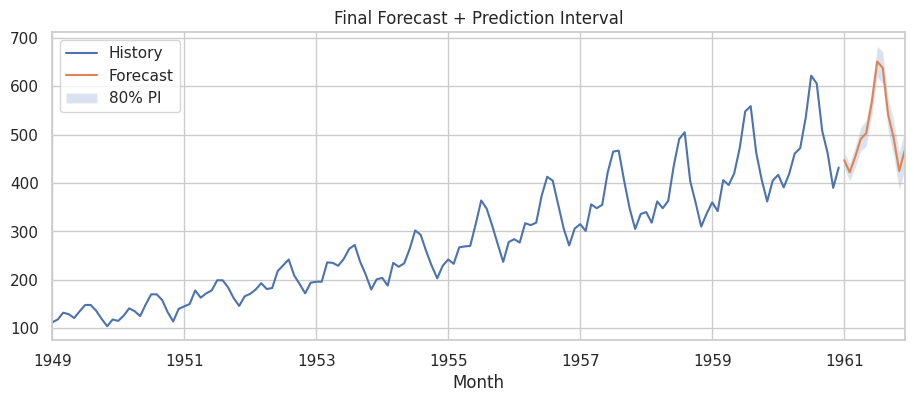

,forecast,lower,upper
1961-01-01,447.235,431.660,462.810
1961-02-01,422.241,403.176,441.306
1961-03-01,454.018,431.968,476.069
1961-04-01,490.703,465.988,515.419
1961-05-01,503.160,476.006,530.314
1961-06-01,565.413,535.992,594.835
1961-07-01,651.215,619.658,682.772
1961-08-01,638.274,604.690,671.857
1961-09-01,540.672,505.151,576.194
1961-10-01,493.031,455.647,530.415


In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

if best_order is None or best_seasonal is None:
    raise RuntimeError("No converged SARIMA model found. (If you used HW fallback, refit that instead.)")

final_model = SARIMAX(
    y,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend="n",
).fit(disp=False)

n_forecast = 12
final_res = final_model.get_forecast(steps=n_forecast)
final_mean = final_res.predicted_mean
final_ci = final_res.conf_int(alpha=0.2)  # 80% PI

plt.figure(figsize=(11,4))
y.plot(label="History")
final_mean.plot(label="Forecast")
plt.fill_between(final_ci.index, final_ci.iloc[:,0], final_ci.iloc[:,1], alpha=0.2, label="80% PI")
plt.title("Final Forecast + Prediction Interval")
plt.legend(); plt.show()

pd.DataFrame({"forecast": final_mean, "lower": final_ci.iloc[:,0], "upper": final_ci.iloc[:,1]})


## 13. Error by Month (Bias Diagnostics)

We check whether a model systematically over/under-forecasts specific months.


In [31]:
best_valid_pred = sarima_pred  # adjust if ETS won
errors = (y_valid - best_valid_pred).to_frame("err")
errors["month"] = errors.index.month_name().str[:3]
err_by_month = errors.groupby("month")["err"].agg(["mean","std"]).reindex(
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
)
err_by_month


,mean,std
month,,
Jan,44.939,38.513
Feb,44.695,32.894
Mar,46.368,7.475
Apr,76.207,44.282
May,79.107,35.127
Jun,64.903,42.943
Jul,91.001,50.759
Aug,75.071,31.704
Sep,77.637,30.328


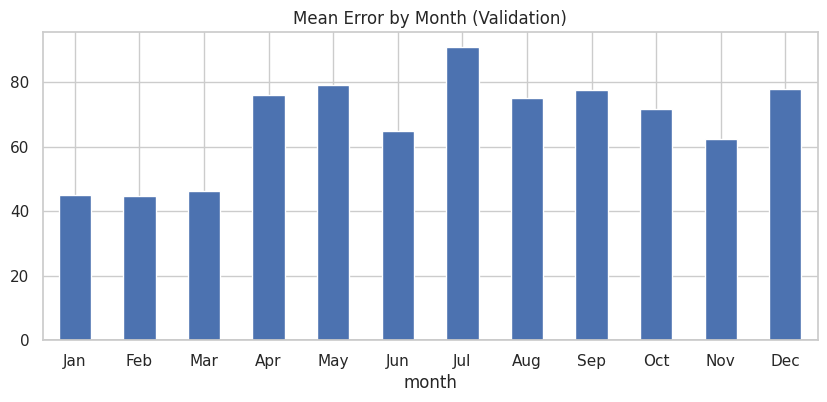

In [32]:
ax = err_by_month["mean"].plot(kind="bar", rot=0, figsize=(10,4), title="Mean Error by Month (Validation)")
ax.axhline(0, color='k', lw=1); plt.show()


## 15. Conclusions

- Airline data shows strong growth with **multiplicative seasonality**.  
- **Seasonal Naive** is a tough yardstick; always include it.  
- **Holt–Winters (mul-mul)** and **compact SARIMA** typically outperform baselines.  
- Residual diagnostics (ACF/PACF, Ljung–Box) help validate assumptions.  
- Rolling-origin CV offers more reliable error estimates than a single split.  
- Always provide **prediction intervals** with point forecasts.

**Deliverable tips**: keep plots tidy, label axes, show a clear scoreboard, and state which model you finally refit + why.


## References

- Hyndman, R.J. & Athanasopoulos, G. *Forecasting: Principles and Practice* (OTexts, free).
- Box, G.E.P., Jenkins, G.M., Reinsel, G.C., & Ljung, G.M. *Time Series Analysis: Forecasting and Control*.
- Statsmodels Documentation: SARIMAX, ExponentialSmoothing, STL.
